In [1]:
import sys
sys.path.append(r'../../Function_library')

import numpy as np
import matplotlib.pyplot as plt
print(np.__version__)
from numba import njit, prange
import seaborn as sns



import sys
sys.path.append('sdeint_source/sdeint')
sys.path.append('sdeint_source')



1.23.5


In [2]:
    
A = 7.0e12 # m^2
secpryr = 3600.0 * 24.0 * 365.0
F0 = 3.0/secpryr # 3 m/yr/(sec/yr) = [m/s]
D = 1000.0 # m (depth of pycnocline)
tc = D/(2*F0*secpryr)
b_c = 0.004 # charateristic buoyancy gradient
B_c = b_c*F0 # characteristic buoyancy flux

psi_0 = -4.5e6 # m^3/s
psi_1 = 20.0e6 # m^3/s¨
psi_a = 5.0e6 # m^3/s (5 Sv) 
chi = 2.5 # area scale factor

q0 = -9.
q1 = 12.
b0 = 0.625
tau = 0.902

alpha, gamma = 0, 1.2


## Make function to plot

In [3]:
N_1 = 10_000
b_null = np.linspace(0.6, 1.58, N_1)
B_null = - abs(q0 + q1*(b_null - b0))*(b_null - b0)

discont_b = -q0/q1 + b0

localminimum_b = (2*q1 *b0 - q0)/(2*q1)
localminimum_B = - abs(q0 + q1*(localminimum_b - b0))*(localminimum_b - b0)

colorblind = sns.color_palette("colorblind")

color_slow_manifold = 'black'
color_bifurcation = colorblind[2]             # muted green as in the paper
color_stable_fixpoint_above = colorblind[1]   # orange
color_stable_fixpoint_below = colorblind[-1]  # light blue
color_unstable_fixpoint = colorblind[4]       # purple


In [4]:
def jacobian_eig(alpha, b):
    if b > discont_b:
        A = np.array([[2*q1*(b0 - b)-q0, 1/tau ], [-1, alpha/tau]])
    
    if b == discont_b:
        A = np.array([[0, 1/tau ], [-1, alpha/tau]])
    
    if b < discont_b:
        A = np.array([[-1*(2*q1*(b0 - b)-q0), 1/tau ], [-1, alpha/tau]])
    return np.linalg.eig(A)[0]

def tot_eig(alpha, N_1 = 100_00):
    b_1 = np.linspace(discont_b, np.max(b_null), N_1)
    eigenvalues_1 = np.zeros((N_1,2), dtype = complex)
    for i in range(N_1):
        eigenvalues_1[i,:] = jacobian_eig(alpha, b_1[i])

    b = discont_b
    A = np.array([[0, 1/tau ], [-1, alpha/tau]])  # b equal to discont_b
    eig_discont_b = jacobian_eig(alpha, b)


    # make a list of all the eigenvalues from 0.5 to discont_b
    b_2 = np.linspace(np.min(b_null), discont_b, N_1)
    eigenvalues_2 = np.zeros((N_1,2), dtype=complex)
    for i in range(N_1):
        eigenvalues_2[i,:] = jacobian_eig(alpha, b_2[i])

    b_tot = np.concatenate((b_2, np.array([b]), b_1))
    eigenvalues_tot = np.concatenate((eigenvalues_2, np.array([eig_discont_b]), eigenvalues_1))
    return b_tot, eigenvalues_tot

def stability_check(alpha,b):
    eig = jacobian_eig(alpha, b)
    if np.real(eig[0]) > 0 or np.real(eig[1]) > 0:
        return 2
    
    if np.abs(eig[0].real) < 1e-3 and np.abs(eig[1].real) < 1e-3:
        return 1
    
    return 0


def analytical_anal(alpha, N_1 = 100_000, verbose = False):

    b_tot, eigenvalues_tot = tot_eig(alpha, N_1 = N_1)
    # find the intervals the one real part of the eig values are >0

    b_unstable_0 = b_tot[np.real(eigenvalues_tot[:,0]) > 0]
    b_unstable_1 = b_tot[np.real(eigenvalues_tot[:,1]) > 0]

    if len(b_unstable_0) == 0:
        start_unstable = np.min(b_unstable_1)
        end_unstable = np.max(b_unstable_1)

    elif len(b_unstable_1) == 0:
        start_unstable = np.min(b_unstable_0)
        end_unstable = np.max(b_unstable_0)

    else:

        start_unstable = np.min((np.min(b_unstable_0), np.min(b_unstable_1)))
        end_unstable = np.max((np.max(b_unstable_0), np.max(b_unstable_1)))

    # find the bifurcation points this is where the eigenvalues are only imaginary

    #mask_im_1 = np.imag(eigenvalues_tot[:,0]) != 0
    mask_real_1 = np.abs(np.real(eigenvalues_tot[:,0])) < 1e-3


    # test if the discontinuity point is a bifurcation point
    is_discont_b_bif = np.abs(np.real(jacobian_eig(alpha, discont_b)[0])) < 1e-30


    # if is_discont_b_bif is True: remove them from the mean calculation
    if is_discont_b_bif:
        #bifurcation_points_1_b = b_tot[mask_im_1 & mask_real_1]
        bifurcation_points_1_b = b_tot[mask_real_1]
        
        bifurcation_points_1_b = np.mean(bifurcation_points_1_b[bifurcation_points_1_b<discont_b])
        bifurcation_points_1_b = np.append(bifurcation_points_1_b,discont_b)

    else:
        if verbose:
            print(b_tot[ mask_real_1])
        bifurcation_points_1_b = np.mean(b_tot[ mask_real_1])
    
    # make bifurcation_points_1_b a numpy array

    if type(bifurcation_points_1_b) != type(np.array([1,2])):

        bifurcation_points_1_b = np.array([bifurcation_points_1_b])
    # the first is the beginning of the unstable part and the second is the end
    # this is the bifurcation point if nan then there is no bifurcation point

    if verbose:
        if np.isnan(bifurcation_points_1_b).any():
            print('no bifurcation point')
        
        else:
            for point in bifurcation_points_1_b:
                print('bifurcation point at: ', point)
                print('has eigenvalues: ', jacobian_eig(alpha, point))


    return start_unstable, end_unstable, bifurcation_points_1_b


def add_fixpoint_and_nullclines(gamma,ax, alpha = 0, color = 'grey',
     verbose = False, N_1 = 100_000, linestyle = '--', linewidth = 3):
    B_null2 = np.linspace(np.min(B_null), np.max(B_null), N_1)
    b_null2 = gamma - alpha * B_null2

    intersections = np.argwhere(np.diff(np.sign(B_null + (b_null-gamma)/alpha))).flatten()



    for point in intersections:
            stab_int = stability_check(alpha, b_null[point])
            color_point = color_unstable_fixpoint   
            if verbose:
                stability_names = ['stabel', 'bifurcation', 'unstable']
                print('\n')
                print('Intersection at (', B_null[point],',', b_null[point],')')
                print('with eigenvalues: ', jacobian_eig(alpha, b_null[point]), stability_names[stab_int])
                
            
            if stab_int == 0:
                if b_null[point] > discont_b:
                        color_point = color_stable_fixpoint_above
                elif b_null[point] < localminimum_b:
                        color_point = color_stable_fixpoint_below
            elif stab_int == 1:
                color_point = color_bifurcation

            ax.plot( B_null[point], b_null[point], 'o', 
            label=r'$\gamma = $' + str(gamma) + ' intersection', 
            color = color_point, markersize=15, markeredgecolor='black')
    
    ax.plot( B_null2, b_null2, label=r'$\gamma = $' + str(gamma), 
    color = color, linewidth=linewidth, linestyle = linestyle)



In [5]:
def plot_stab_anal(ax,alpha, gamma, x_1 = 0.6, x_2 = 1.6, y_1 = -2.5, y_2 = 0.5, N = 10_000
                    , verbose = False):

    if verbose:
        print('='*85)
        print('Analysis of: alpha =', alpha, ' gamma = ', gamma)

    start_unstable, end_unstable, bifurcation_points = analytical_anal(alpha, verbose = verbose)

    #print(start_unstable, end_unstable, bifurcation_points)

    # plot the lower stable manifold
    cuttoff_lower = np.argmin(np.abs(b_null - start_unstable))
    ax.plot( B_null[:cuttoff_lower], b_null[:cuttoff_lower], color=color_stable_fixpoint_below,
                    linewidth=5)

    # plot the upper stable manifold
    cuttoff_upper = np.argmin(np.abs(b_null - end_unstable))
    ax.plot( B_null[cuttoff_upper:], b_null[cuttoff_upper:], color=color_stable_fixpoint_above,
                    linewidth=5)

    # plot the unstable manifold
    ax.plot( B_null[cuttoff_lower:cuttoff_upper], b_null[cuttoff_lower:cuttoff_upper], color=color_unstable_fixpoint,
            linestyle='--', linewidth=5)

    if verbose:
        print('unstable range is:', b_null[cuttoff_lower], b_null[cuttoff_upper])



    # make the bifurcation points a larger circle with a black outline

    if not np.isnan(bifurcation_points[0]):    
        for point in bifurcation_points:
            # find the closed B to the bifurcation point
            ind = np.argmin(np.abs(b_null - point))
            B_biff = B_null[ind]
            ax.plot( B_biff, point,'o', color = color_bifurcation, markersize=15, 
                                markeredgecolor='black')



    add_fixpoint_and_nullclines(gamma, ax,alpha, verbose = verbose)

    # make N*N point grid two make a vector field using quiver

    N = 1000


    y = np.linspace(y_1,y_2, N)
    x = np.linspace(x_1,x_2, N)

    X, Y = np.meshgrid(x, y)

    # calculate the slope of the vector field
    delta_b = X
    B = Y
    d_delta_b = d_delta_b_dt(delta_b, B, q0, q1, b0)
    dB = dB_dt(delta_b, B, gamma, alpha)




    ax.set_ylim(x_1,x_2)
    ax.set_xlim(y_1,y_2)
    nn = 1
    ax.streamplot(y, x, dB.T, d_delta_b.T, color = 'grey', density = 1.5,
                    linewidth = 1, arrowsize = 1, arrowstyle = '->',
                    start_points = np.flip(np.vstack((X[nn:-nn,nn:-nn].flatten(), Y[nn:-nn,nn:-nn].flatten())).T, axis = 1))


In [6]:
import warnings
warnings.filterwarnings("ignore")

# Make gif

Takes a long time to run grap a cup of cofee maybe two

NameError: name 'd_delta_b_dt' is not defined

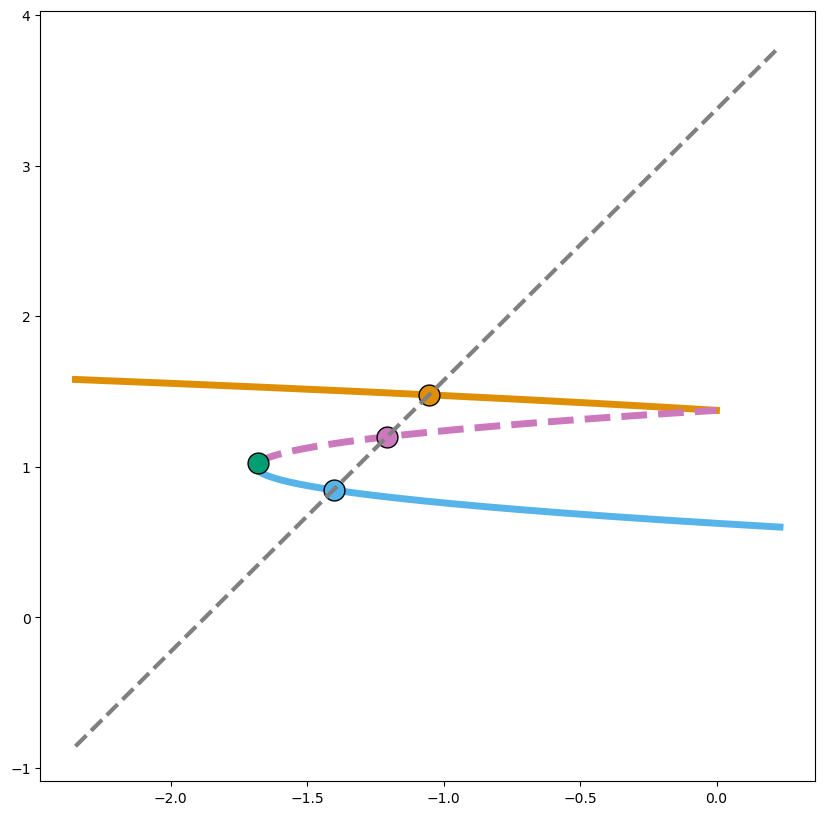

In [7]:
from celluloid import Camera
from matplotlib import animation
gif = True

N = 1000

alphas = np.linspace(-1.8,0.5, N)
Px, Py =  -1.2075, 1.2

Px = -np.abs(q0+q1*(Py-b0))*(Py-b0)
gammas = alphas*Px + Py

if gif:
    fig,ax = plt.subplots(figsize=(10,10))
    camera = Camera(fig)
    for i in range(len(alphas)):
        plot_stab_anal(ax,alphas[i], gammas[i])
        camera.snap()
    animation = camera.animate()

In [ ]:
animation.save('first.gif', writer='pillow', fps=4)


## Make 2x2 plots

0
1
2
3


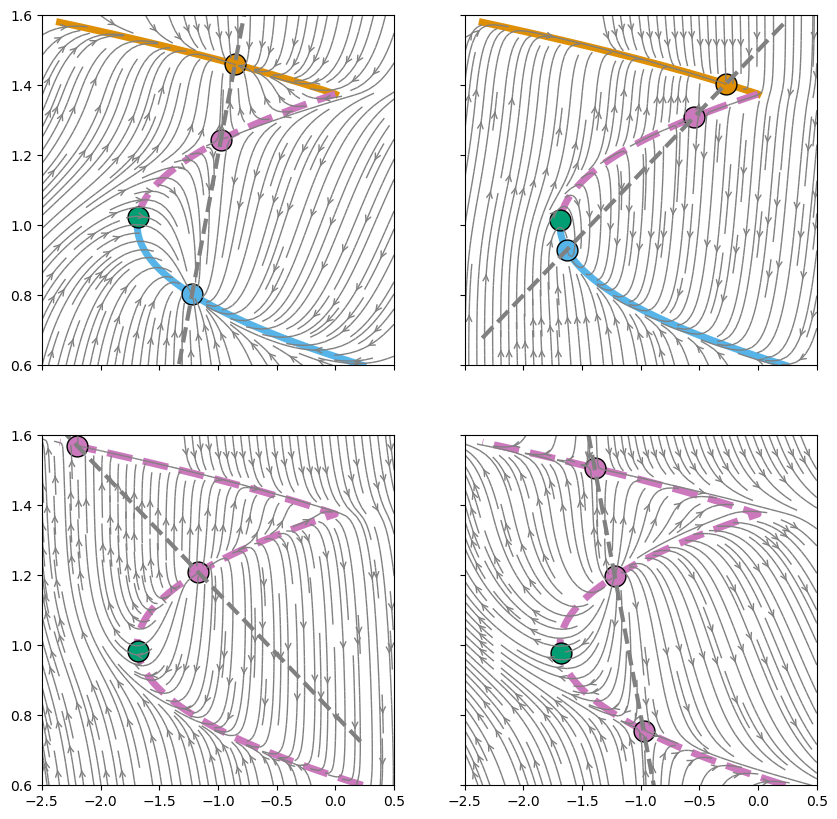

In [ ]:
fig,ax = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)
ax = ax.flatten()

alphas = np.array([-1.8,-0.35,0.35,1.8])
gammas = np.array([3,1.5,0.8,-1])
for i in range(len(ax)):
    print(i)
    plot_stab_anal(ax[i],alphas[i], gammas[i], verbose= False)



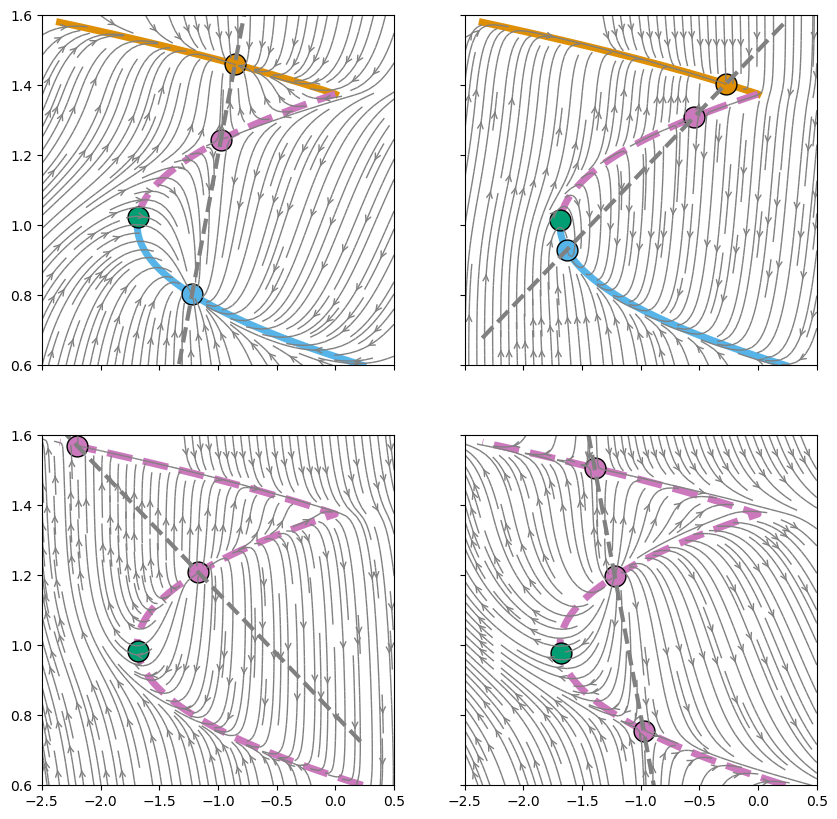

In [ ]:
fig,ax = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)
ax = ax.flatten()

alphas = np.array([-1.8,-0.35,0.35,1.8])
gammas = np.array([3,1.5,0.8,-1])
for i in range(len(ax)):
    plot_stab_anal(ax[i],alphas[i], gammas[i])


